In [13]:
from torch import nn
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [14]:
dataSetDir = "../Brain_tumor_MRI_classification_CNN/Brain Tumor MRI"
print(os.listdir(dataSetDir))

['Testing', 'Training']


In [16]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

# Load the dataset
train_dataset = datasets.ImageFolder(root=dataSetDir + '/Training', transform=transform)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2)

# Function to compute mean and std
def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        batch_size = images.size(0)  # Get the current batch size
        images = images.view(batch_size, images.size(1), -1)  # Reshape for easier computation
        mean += images.mean(2).sum(0)  # Sum the mean across the batch
        std += images.std(2).sum(0)    # Sum the std across the batch
        total_images_count += batch_size  # Count total images processed

    mean /= total_images_count  # Average the mean
    std /= total_images_count    # Average the std
    return mean, std

# Calculate and print mean and std
mean, std = get_mean_std(train_loader)
print(f"Mean: {mean}")
print(f"Std: {std}")


Mean: tensor([0.1794, 0.1794, 0.1794])
Std: tensor([0.1699, 0.1699, 0.1699])


In [19]:
trainTransform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

testTransform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [23]:
MRI = {}
MRI['train'] = datasets.ImageFolder(root=dataSetDir + '/Training', transform=trainTransform)
MRI['test'] = datasets.ImageFolder(root=dataSetDir + '/Testing', transform = testTransform)
MRI

{'train': Dataset ImageFolder
     Number of datapoints: 2870
     Root location: ../Brain_tumor_MRI_classification_CNN/Brain Tumor MRI/Training
     StandardTransform
 Transform: Compose(
                Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=tensor([0.1794, 0.1794, 0.1794]), std=tensor([0.1699, 0.1699, 0.1699]))
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 394
     Root location: ../Brain_tumor_MRI_classification_CNN/Brain Tumor MRI/Testing
     StandardTransform
 Transform: Compose(
                Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=tensor([0.1794, 0.1794, 0.1794]), std=tensor([0.1699, 0.1699, 0.1699]))
            )}

In [25]:
trainLoader = DataLoader(dataset=MRI['train'], batch_size=32, shuffle=True, num_workers=2)
testLoader = DataLoader(dataset=MRI['test'], batch_size=32, shuffle=True, num_workers=2)


In [27]:
classes = MRI['train'].classes
classes

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [29]:
class_index = MRI['test'].class_to_idx
class_index

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [31]:
image, label = next(iter(trainLoader))
image.shape

torch.Size([32, 3, 150, 150])

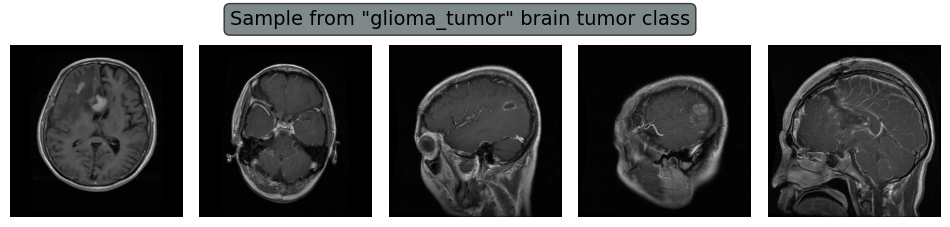

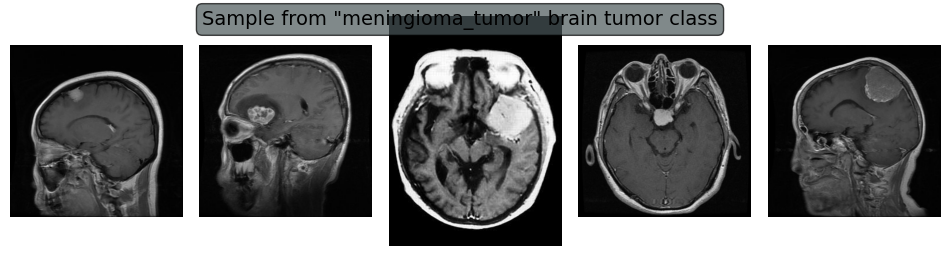

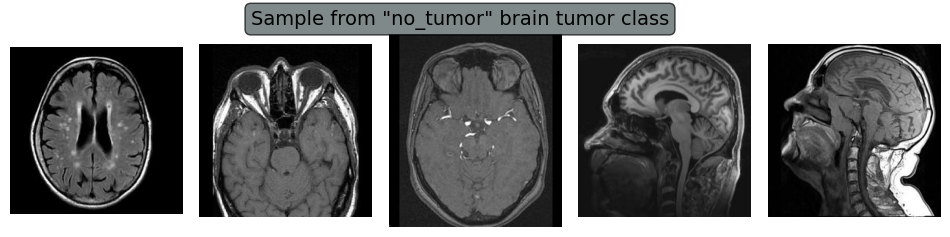

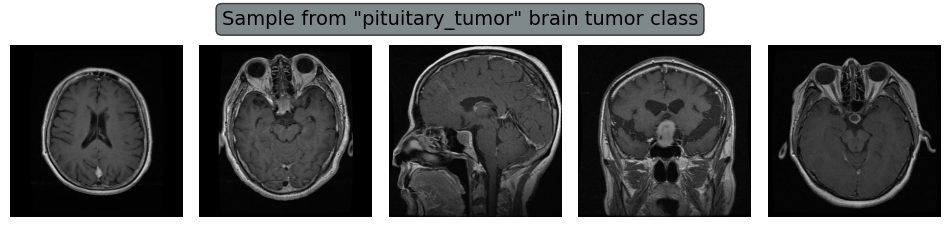

In [34]:
import random
import matplotlib.pyplot as plt
from PIL import Image
# Plotting random images of each file(class)

for brain_tumor_class in classes : # Loop through each class
    
    # Accessing images in files 
    class_dir = os.path.join(dataSetDir + '/Training' , brain_tumor_class) # The image path of the rice class
    images_path = os.listdir(class_dir) # List of images
    random_images = random.sample(images_path , k = 5) # Random sample of images
    
    # Plotting some sample images
    fig , ax = plt.subplots(1 , 5 , figsize = (12 , 3)) 
    plt.suptitle(f'Sample from "{brain_tumor_class}" brain tumor class', fontsize = 14 
                 , bbox=dict(facecolor='#4A5759', alpha=0.7 , boxstyle='round,pad=0.3') , y = 0.9) # Title for each sample
    
    for i , random_image in enumerate(random_images) : # Loop for each image
        image_path = os.path.join(class_dir , random_image) # Creating image path
        image = Image.open(image_path) # Load image
        
        ax[i].imshow(image) # Plot image
        ax[i].axis('off') # Remove the axis
    
    plt.subplots_adjust( hspace = -0.2 , wspace = 0.1 )
    plt.show()
    print('\n')